### Test case LVV-T1749 - Verify calculation of fraction of relative astrometric measurement error on 20 arcminute scales exceeding outlier limit

Verify that the DM system has provided the code to calculate the maximum fraction of relative astrometric measurements on 20 arcminute scales that exceed the 20 arcminute outlier limit **AD2 = 20 milliarcseconds**, and assess whether it meets the requirement that it shall be less than **AF2 = 10 percent**.

#### Discussion:

This test can be verified using data products produced during regular reprocessing campaigns executed by the Data Management pipelines team. In particular, we will use the regularly-reprocessed HSC RC2 data as reprocessed with weekly pipelines version w_2024_34, in Butler collection “HSC/runs/RC2/w_2024_34/DM-45857".

The `AF2` metric and related plots are created by tasks in the `analysis_tools` package. Thus verification of this requirement can be accomplished by simply retrieving the datasets produced by those tasks and confirming that they meet the requiremed accuracy.

In [1]:
import matplotlib.pyplot as plt

from lsst.daf.butler import Butler
from IPython.display import Image

In [2]:
# Initialize the butler repo pointing to the DM-45857 (w_2024_34) collection
repo = '/repo/main'
collection = 'HSC/runs/RC2/w_2024_34/DM-45857'

butler = Butler(repo, collections=collection)

Select one of the three tracts in the RC2 dataset (either 9615, 9697, or 9813). Then fetch the metrics from matching `objectTable_tract` to the Gaia DR3 refcat.

In [3]:
did_tract9615 = {'instrument':'HSC', 'tract':9615, 'skymap':'hsc_rings_v1'}
metric_extract9615 = butler.get('matchedVisitCore_metrics', collections=collection, dataId=did_tract9615)
did_tract9697 = {'instrument':'HSC', 'tract':9697, 'skymap':'hsc_rings_v1'}
metric_extract9697 = butler.get('matchedVisitCore_metrics', collections=collection, dataId=did_tract9697)
did_tract9813 = {'instrument':'HSC', 'tract':9813, 'skymap':'hsc_rings_v1'}
metric_extract9813 = butler.get('matchedVisitCore_metrics', collections=collection, dataId=did_tract9813)

Print the metrics to the screen:

In [5]:
print('Tract 9615:\n')
for met in metric_extract9615['stellarAstrometricRepeatability2']:
    if ('AF2' in met.metric_name.metric) and \
       (met.metric_name.metric.startswith('g_') or met.metric_name.metric.startswith('r_') or \
        met.metric_name.metric.startswith('i_')):
        print(met.datum)

print('\nTract 9697:\n')
for met in metric_extract9697['stellarAstrometricRepeatability2']:
    if ('AF2' in met.metric_name.metric) and \
       (met.metric_name.metric.startswith('g_') or met.metric_name.metric.startswith('r_') or \
        met.metric_name.metric.startswith('i_')):
        print(met.datum)

print('\nTract 9813:\n')
for met in metric_extract9813['stellarAstrometricRepeatability2']:
    if ('AF2' in met.metric_name.metric) and \
       (met.metric_name.metric.startswith('g_') or met.metric_name.metric.startswith('r_') or \
        met.metric_name.metric.startswith('i_')):
        print(met.datum)

Tract 9615:

g_AF2 = 0.056792018419033 %
r_AF2 = 0.04708780063749638 %
i_AF2 = 0.44838105038773934 %

Tract 9697:

g_AF2 = 2.0060957760060614 %
r_AF2 = 1.081161689594751 %
i_AF2 = 0.05548913674036633 %

Tract 9813:

g_AF2 = 0.7005543674105357 %
r_AF2 = 1.3457338124427536 %
i_AF2 = 1.3252626295841194 %


The fraction of outliers in relative astrometric measurements on 20 arcminute scales for each band is given by `"band"_AF2`. We see that for all bands and all tracts, `AF2` is well below the 10% threshold.

### Plots associated with the metrics

Retrieve the plots that are created alongside the metrics by `analysis_tools`, and display them in the notebook.

Extract the byte-level data for the images into a dict, which we will then use to display the plots:

In [6]:
plot_dict = {}

for band in ['g', 'r', 'i']:
    plot_name = f"matchedVisitCore_{band}_stellarAstrometricRepeatability2_HistPlot"
    ref = butler.registry.findDataset(plot_name, did_tract9615, collections=collection)
    uri = butler.getURI(ref)
    image_bytes = uri.read()
    plot_dict[plot_name] = image_bytes

Display the plots. Note that I manually entered the key to the plot dict in each of the following 3 cells. For some reason they don't display if I loop over them...

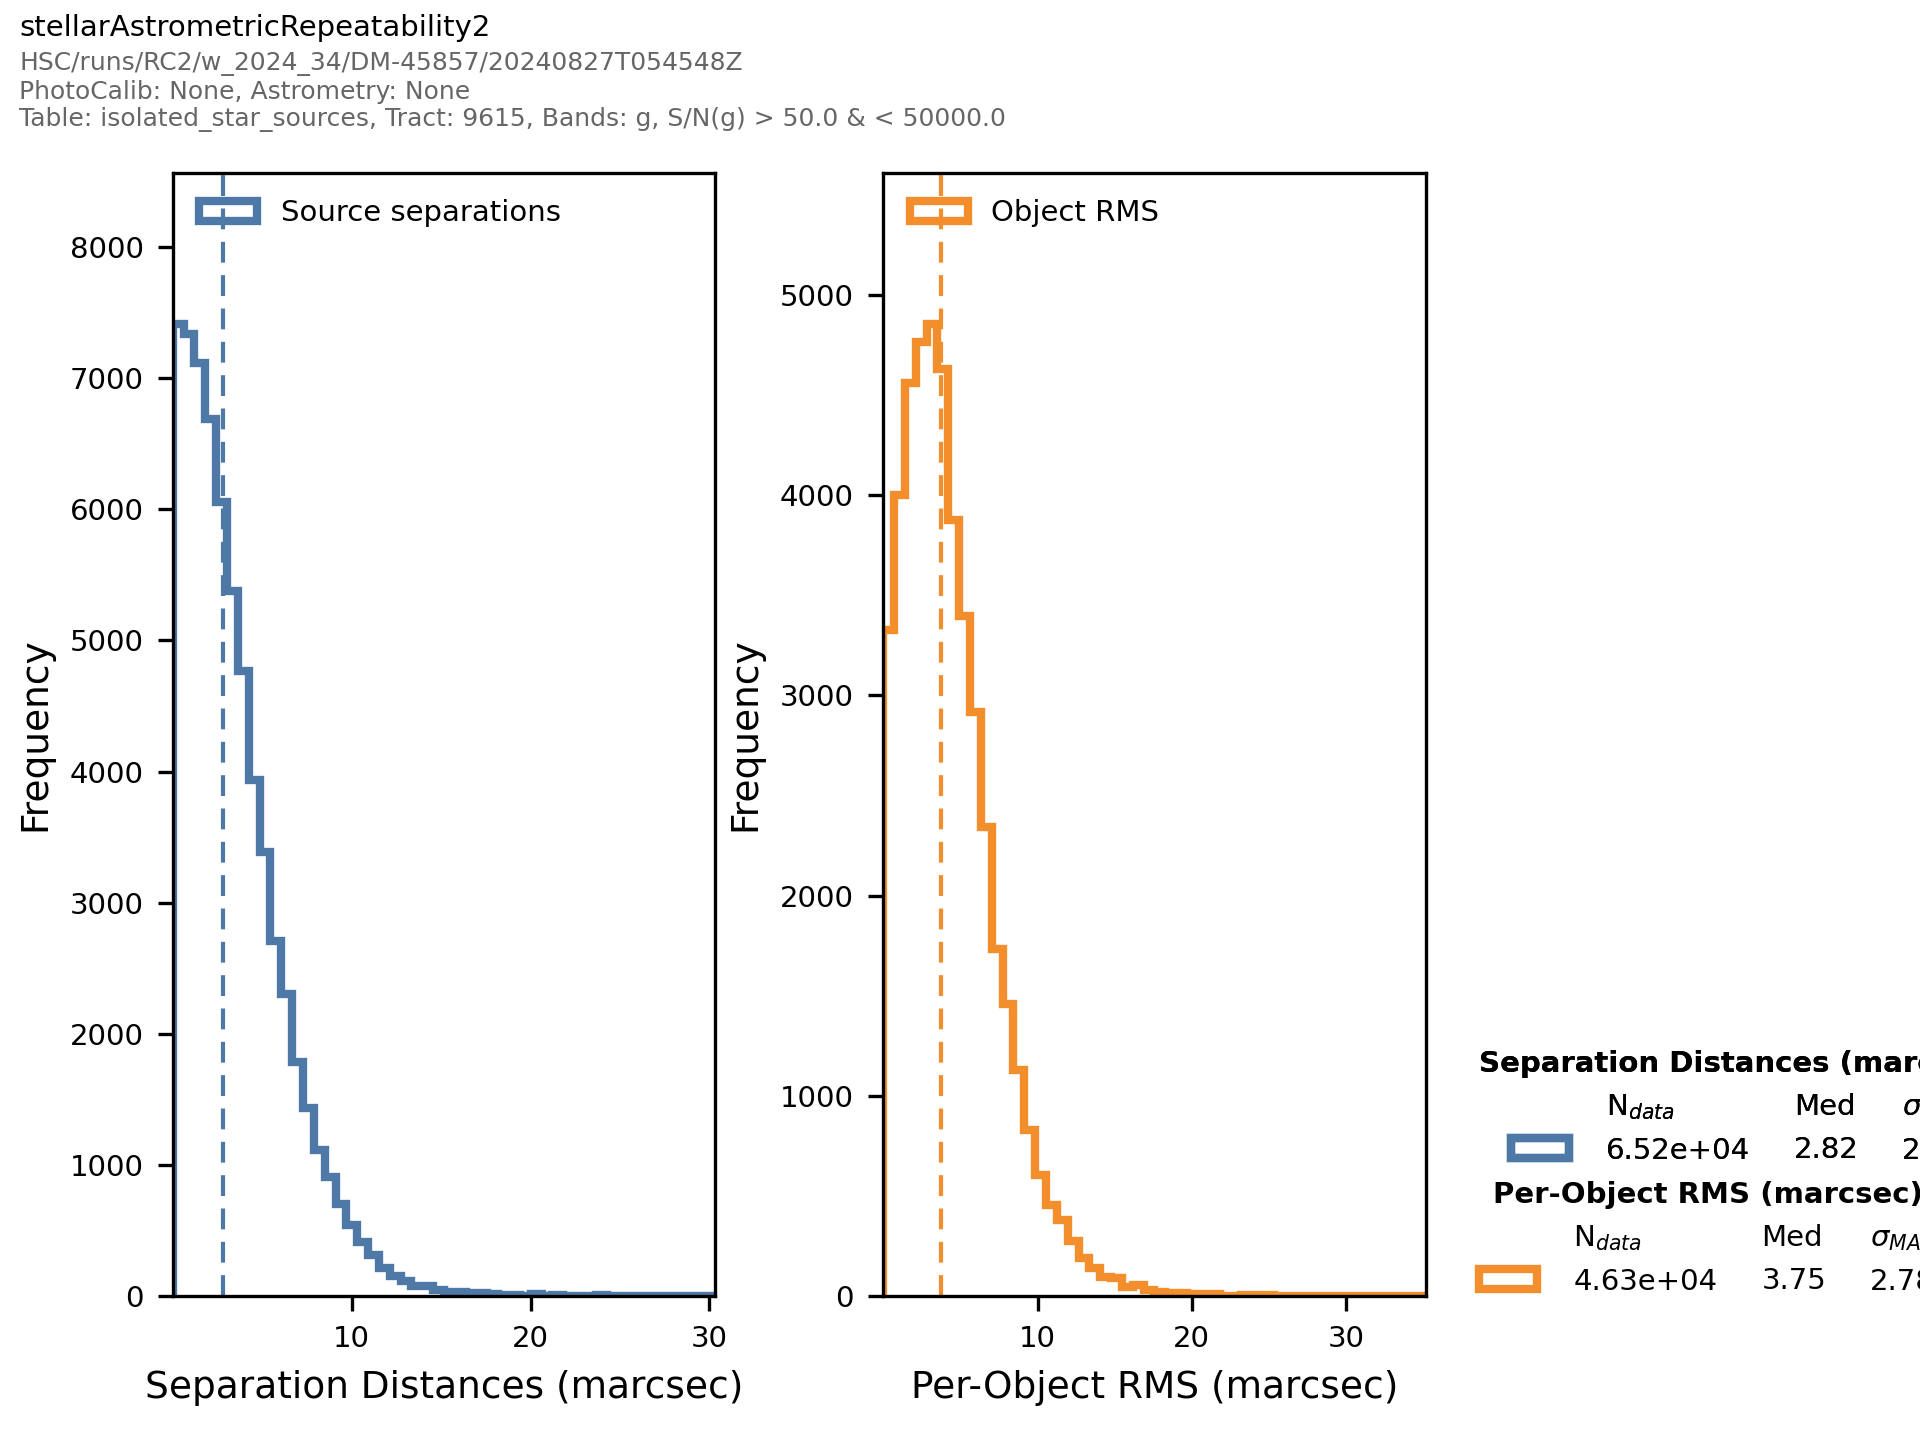

In [7]:
Image(plot_dict['matchedVisitCore_g_stellarAstrometricRepeatability2_HistPlot'], width=600)

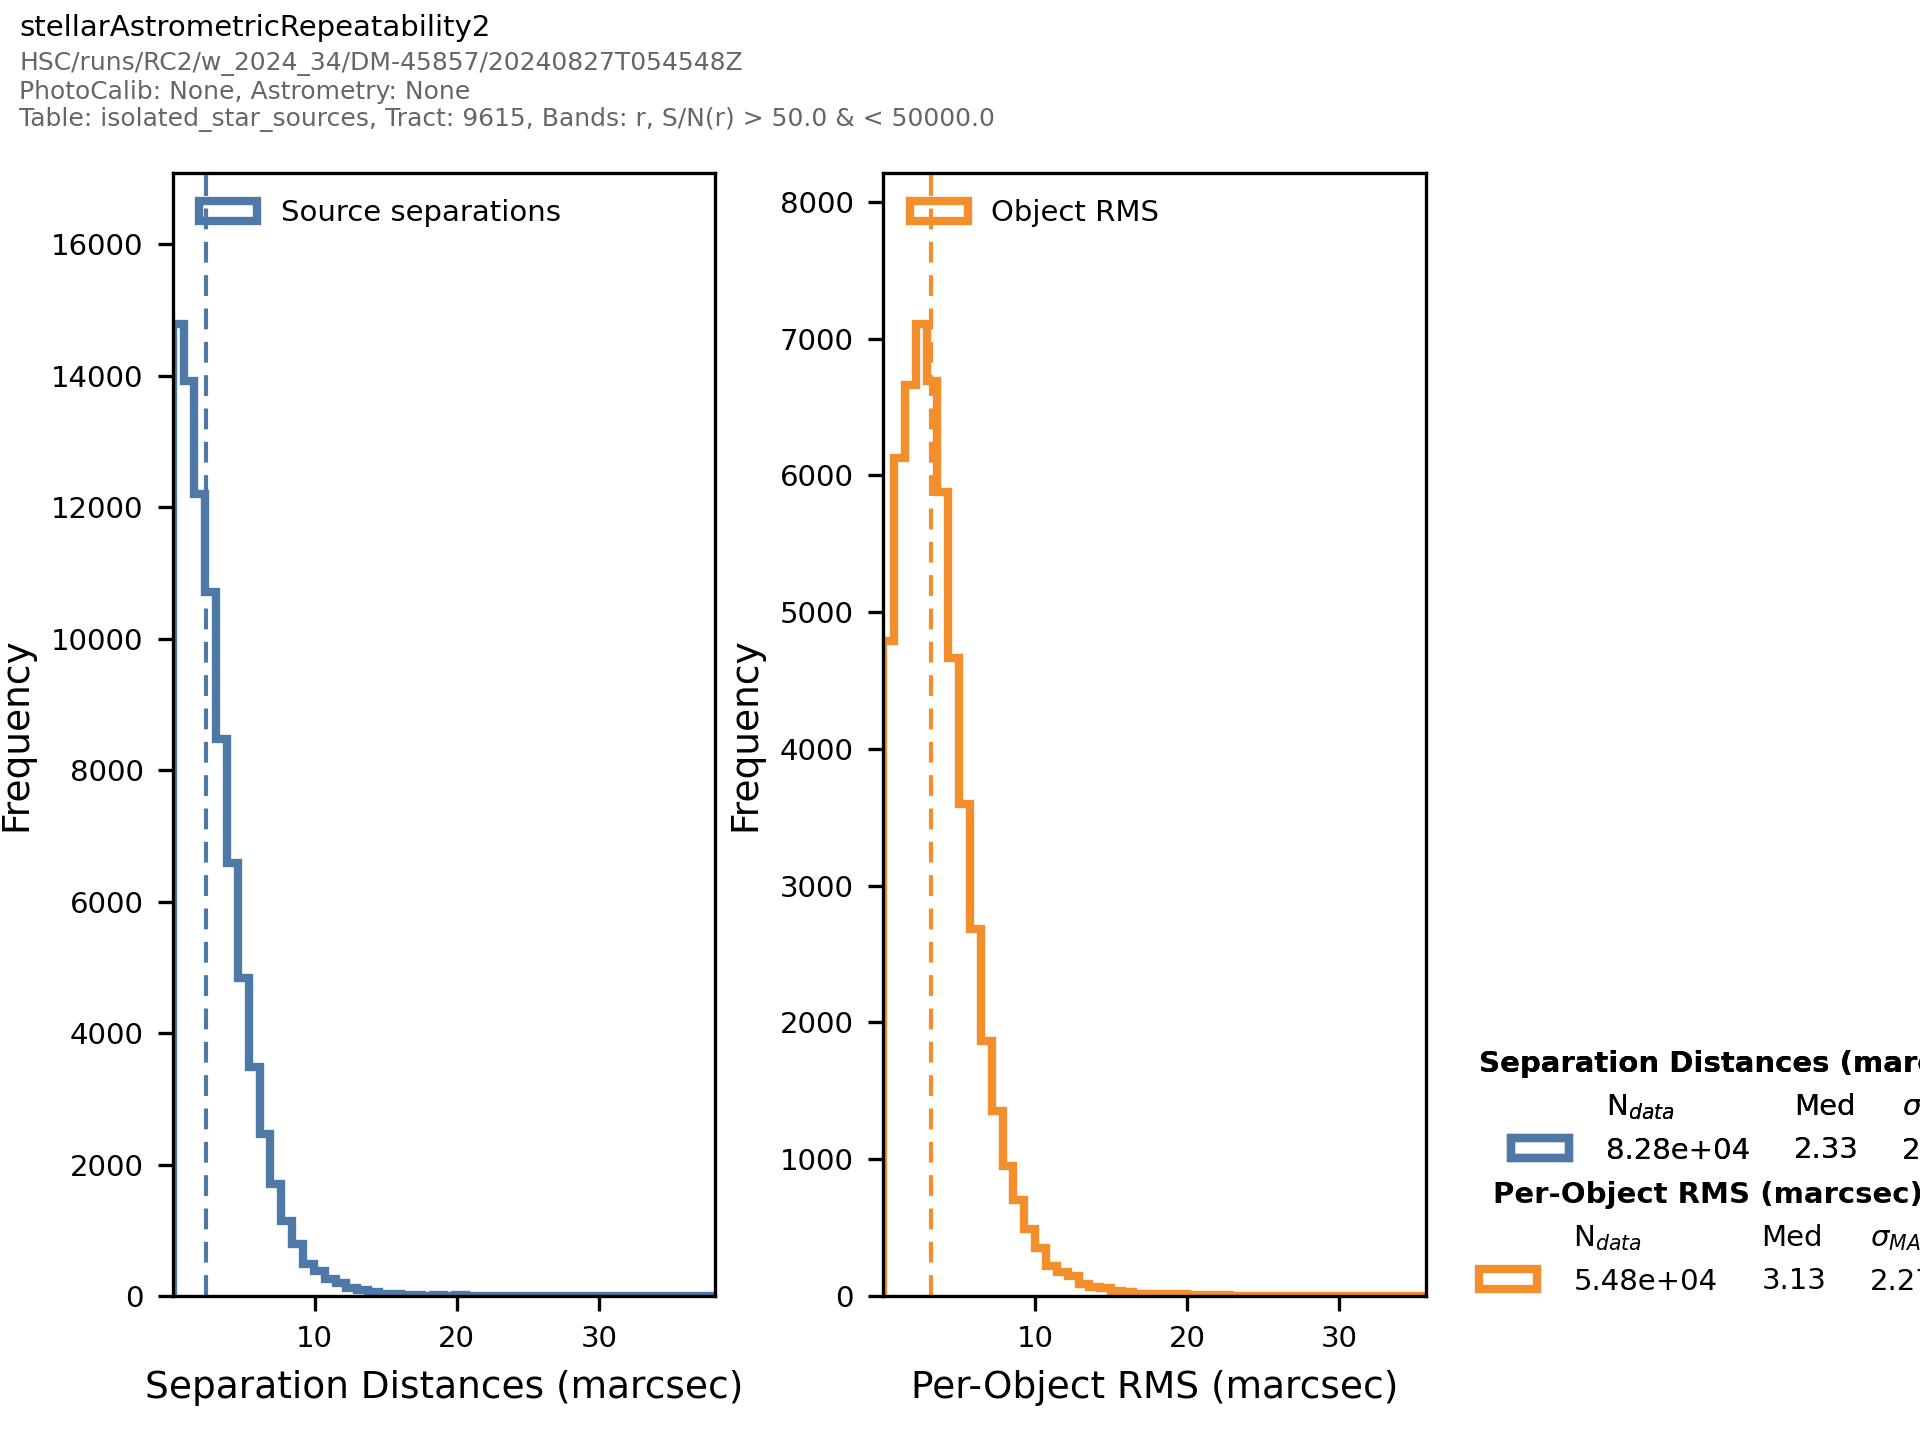

In [8]:
Image(plot_dict['matchedVisitCore_r_stellarAstrometricRepeatability2_HistPlot'], width=600)

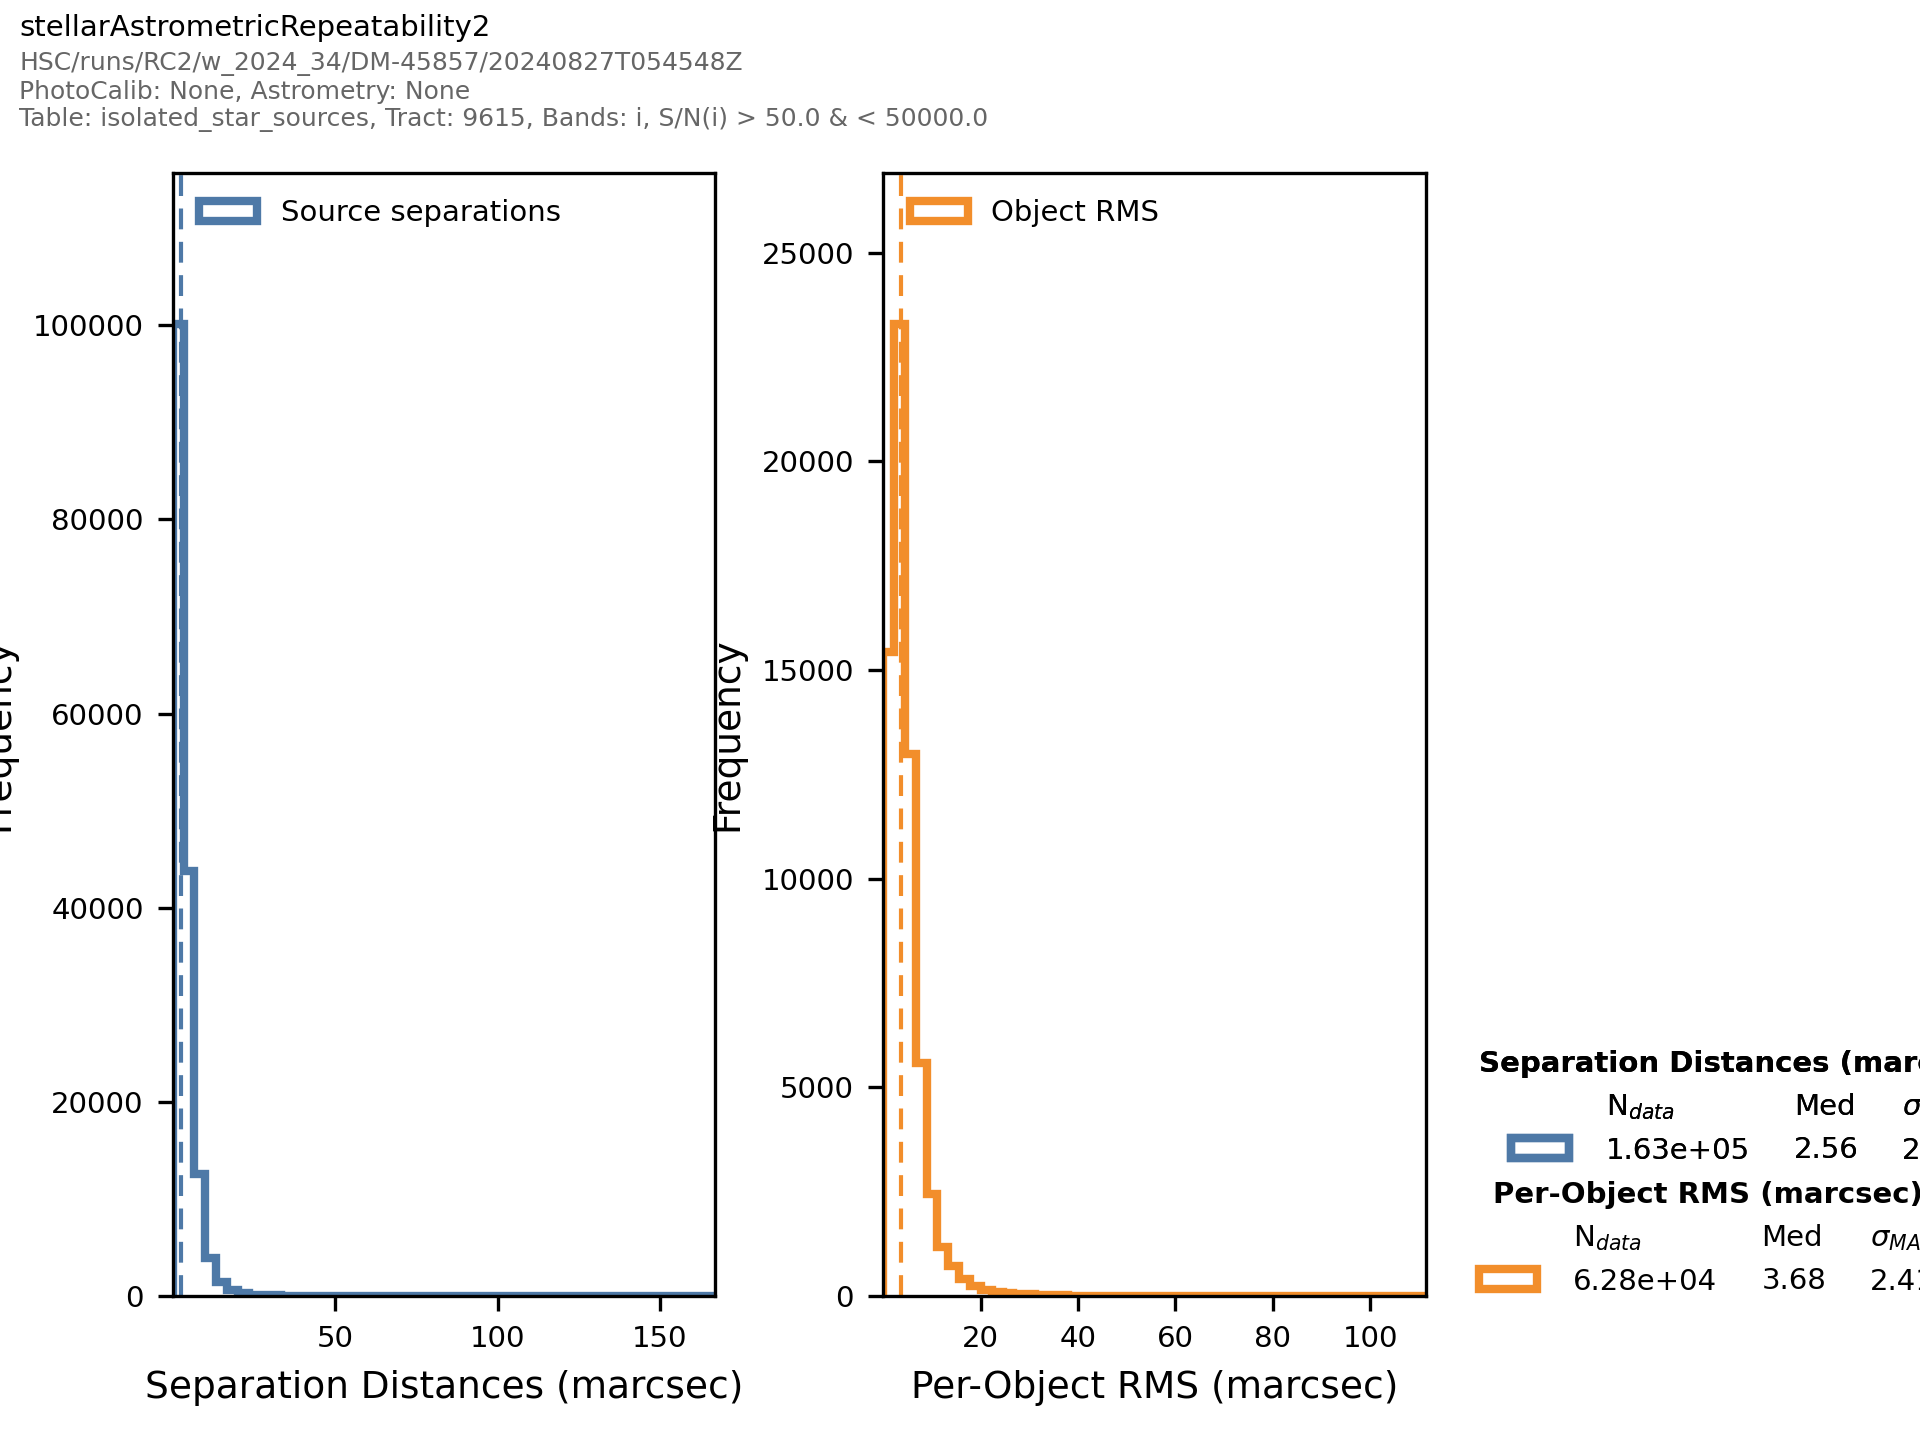

In [9]:
Image(plot_dict['matchedVisitCore_i_stellarAstrometricRepeatability2_HistPlot'], width=600)

### Metric monitoring

The figure below shows a section of our metrics monitoring dashboard, illustrating the tracking of AF2 metrics from July 2023 to the present. In particular, this panel shows AF2 measurements over that time period from the monthly reprocessing of the RC2 dataset, tract 9813.

Note also that AF2 metrics are reported in the Characterization Metrics Report accompanying each major Rubin Science Pipelines release. Examples can be seen at 
[DMTR-431 (v27)](https://docushare.lsst.org/docushare/dsweb/Get/Version-81383/DMTR-431.pdf), [DMTR-421 (v26)](https://docushare.lsst.org/docushare/dsweb/Get/Version-79715/DMTR-421.pdf), [DMTR-392 (v25)](https://docushare.lsst.org/docushare/dsweb/Get/Version-77645/DMTR-392.pdf), which correspond to release versions 27, 26, and 25 of the pipelines.

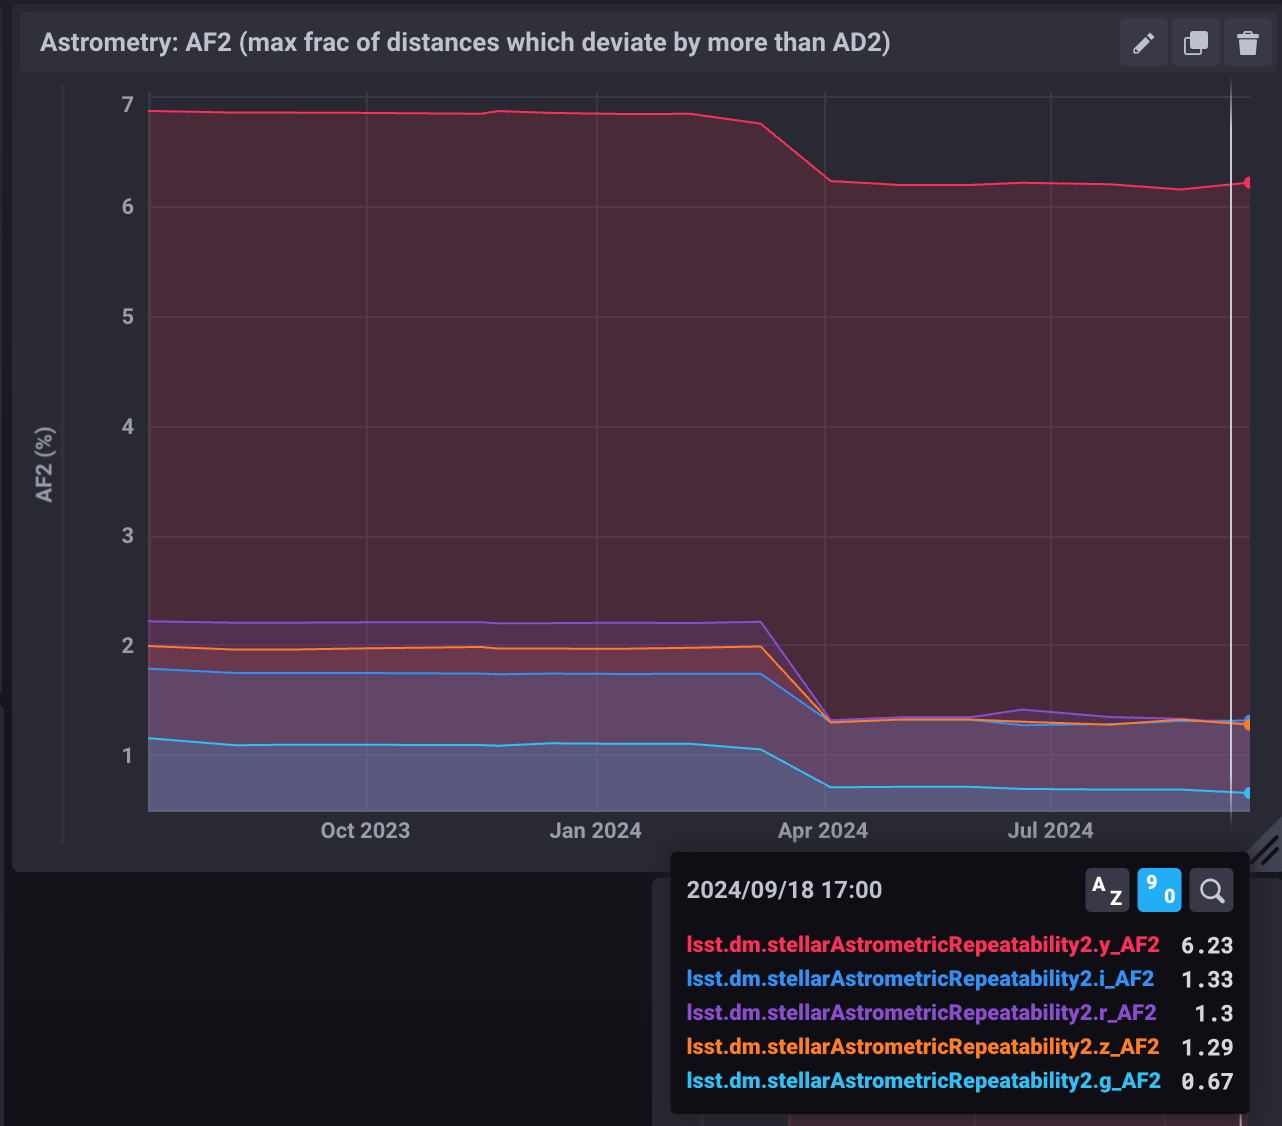

In [10]:
Image("figures/chronograf_AF2_history_jul2023_oct2024.png", width=600)

### Thresholds

To demonstrate that the AD2 threshold (and a related AF2 threshold, which is used to calculate the residual value at the AF2 threshold percentage) is applied, we inspect the relevant lines of `analysis_tools` [code that sets the AD2 and AF2 thresholds](https://github.com/lsst/analysis_tools/blob/2b45b7d01314f84ce12d05144fb9ae7110de62b8/python/lsst/analysis/tools/actions/keyedData/calcDistances.py#L49-L52). We see the following, indicating that the thresholds are being applied as required:
```
    threshAD = Field[float](doc="Threshold in mas for AFx calculation.", default=20.0)
    threshAF = Field[float](
        doc="Percentile of differences that can vary by more than threshAD.", default=10.0
    )

```

## Results
We have demonstrated that there is software within the Rubin Science Pipelines to calculate `AF2`, the maximum fraction of relative astrometric measurements on 20 arcminute scales that exceed the 5 arcminute outlier limit. Additionally we have shown the metrics and plots that are produced by `analysis_tools` each time the DRP pipeline is executed, and shown that the DM code is applying the proper thresholds. Thus the result of this test is a "**Pass**".